(110, 4)
File is saved as order_manual.csv
k


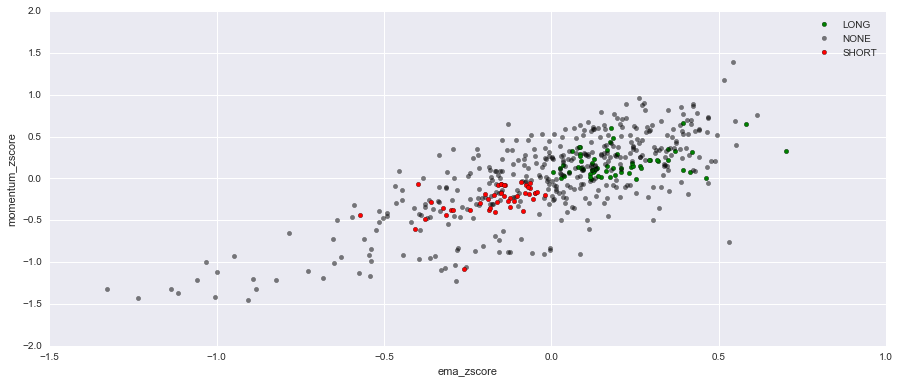

In [7]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from datetime import datetime, timedelta
from util import get_data, plot_data
from indicators import indicators

def rule_based():
    start_date = dt.datetime(2008,1,1)
    end_date = dt.datetime(2009,12,31)
    symbols = ['AAPL']
    df = indicators(sd = start_date, ed = end_date,\
        syms = symbols,gen_plot = False,n=10,verbose=False)

    df_close = pd.DataFrame(index=df.index)

    remaining_days=0
    last_order=''
    for i in range(df.shape[0]):
        remaining_days = remaining_days -1

        df.ix[i,'remaining_days'] = remaining_days
        if remaining_days==1:
                df_close.ix[i,'Order'] = "BUY" if  last_order=="SELL" else "SELL"
                last_order=''

        lookback=4
        if df.ix[i,'momentum']>0:
            #if df.ix[i,'sma']>0 and (df.ix[i-lookback:i,'sma']<0).any() or df.ix[i,'ema']>0 and (df.ix[i-lookback:i,'ema']<0).any() :
            if  df.ix[i,'sma']>0 and df.ix[i,'ema']>0 and (df.ix[i-lookback:i,'ema']<0).any()  :
                df.ix[i,'Order'] = "BUY"
                remaining_days = 21
                last_order='BUY'
                df.ix[i,'remaining_days'] = remaining_days
        else:
            #if df.ix[i,'sma']<0 and (df.ix[i-lookback:i,'sma']>0).any() or df.ix[i,'ema']<0 and (df.ix[i-lookback:i,'ema']>0).any() :
            if df.ix[i,'sma']<0 and df.ix[i,'ema']<0 and (df.ix[i-lookback:i,'ema']>0).any()  :
                df.ix[i,'Order'] = "SELL"
                remaining_days = 21
                last_order='SELL'
                df.ix[i,'remaining_days'] = remaining_days

    signal_close = pd.DataFrame(data=df_close.Order, index=df_close.index)
    signal_close = signal_close[pd.isnull(signal_close.Order)==False]

    signal = pd.DataFrame(data=df.Order, index=df.index)
    signal = signal[pd.isnull(signal.Order)==False]

    signal_merge = pd.concat([signal,signal_close])
    signal_merge = signal_merge.sort_index()
    signal_merge.ix[:,'Date'] = signal_merge.index
    signal_merge.ix[:,'Symbol'] = 'AAPL'
    signal_merge.ix[:,'Shares'] = '200'
    signal_merge.to_csv('order_manual.csv',index=False)
    print signal_merge.shape
    print 'File is saved as order_manual.csv'
    return signal,signal_close,signal_merge,df

plt.rcParams["figure.figsize"] = [15,6]  
signal,signal_close,signal_merge,df=rule_based()
df.ema_zscore =  df.ema_zscore/3.2
df.momentum_zscore =  df.momentum_zscore/2.1
df_buy = df[df.Order=="BUY"]
df_sell = df[df.Order=="SELL"]
df_norm = df[pd.isnull(df.Order)]

ax = df_buy.plot(kind='scatter',x='ema_zscore', y='momentum_zscore',color='Green', label='LONG');
ax2 = df_norm.plot(kind='scatter',x='ema_zscore', y='momentum_zscore',color='Black', label='NONE',ax=ax,alpha=0.5);
df_sell.plot(kind='scatter', x='ema_zscore', y='momentum_zscore',color='Red', label='SHORT', ax=ax2);

    

(106, 4)
File is saved as order_ml.csv


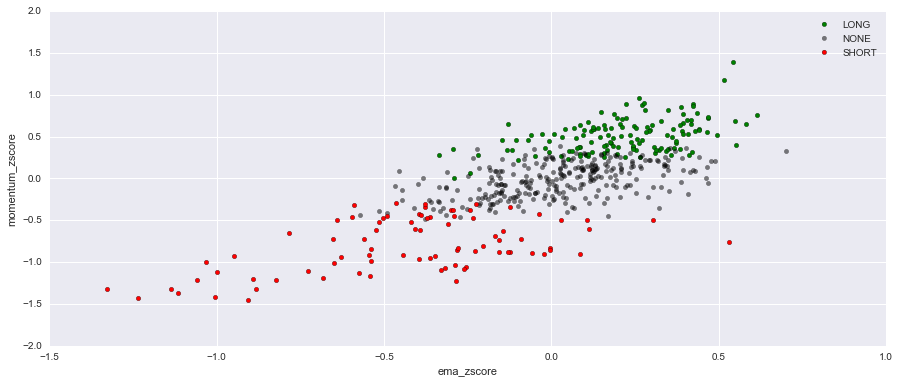

In [10]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from indicators import indicators
from util import get_data
from datetime import datetime, timedelta
import RTLearner as rt
import BagLearner as bl
from indicators import indicators

def ml_based(YBUY= 0.1,YSELL= -0.1,BAGS = 20):
    #INDICATORS
    start_date = dt.datetime(2008,1,1)
    end_date = dt.datetime(2009,12,31)
    df = indicators(sd = start_date, ed = end_date,syms = ['AAPL'],gen_plot = False,n=10,verbose=False)
    dates = pd.date_range(df.index[0]+timedelta(days=-50), df.index[-1])

    prices_all = get_data(['AAPL'], dates)
    prices_all.ix[:,'return'] = ( prices_all.ix[21:,'AAPL'] /prices_all.ix[0:-21,'AAPL'].values ) -1
    df.ix[:,'return'] = prices_all.ix[:,'return']
    for i in df.index:
        if df.ix[i,'return']>YBUY:
            df.ix[i,'Y'] = 1
        elif df.ix[i,'return']<YSELL:
            df.ix[i,'Y'] = -1
        else:
            df.ix[i,'Y'] = 0

    tx = df[['sma_zscore','ema_zscore','momentum_zscore']].values
    ty=df['Y'].values
    #learner = rt.RTLearner(LEAVE_SIZE) # create a RTLearner
    learner = bl.BagLearner(bags=BAGS)
    learner.addEvidence(tx, ty) # train it
    predY = learner.query(tx) # get the predictions

    #SETUP THE ORDERING
    df_close = pd.DataFrame(index=df.index)
    remaining_days=0
    last_order=''
    for i in range(df.shape[0]):
        remaining_days = remaining_days -1

        df.ix[i,'remaining_days'] = remaining_days
        if remaining_days==1:
                df_close.ix[i,'Order'] = "BUY" if  last_order=="SELL" else "SELL"
                last_order=''

        if predY[i]==1:
            df.ix[i,'Order'] = "BUY"
            remaining_days = 21
            last_order='BUY'
            df.ix[i,'remaining_days'] = remaining_days
        elif predY[i]==-1:
            df.ix[i,'Order'] = "SELL"
            remaining_days = 21
            last_order='SELL'
            df.ix[i,'remaining_days'] = remaining_days

    signal_close = pd.DataFrame(data=df_close.Order, index=df_close.index)
    signal_close = signal_close[pd.isnull(signal_close.Order)==False]

    signal = pd.DataFrame(data=df.Order, index=df.index)
    signal = signal[pd.isnull(signal.Order)==False]

    signal_merge = pd.concat([signal,signal_close])
    signal_merge = signal_merge.sort_index()
    signal_merge.ix[:,'Date'] = signal_merge.index
    signal_merge.ix[:,'Symbol'] = 'AAPL'
    signal_merge.ix[:,'Shares'] = '200'
    signal_merge.to_csv('order_ml.csv',index=False)
    print signal_merge.shape
    print 'File is saved as order_ml.csv'
    return signal,signal_close,signal_merge,df

signal,signal_close,signal_merge,df = ml_based()
df.ema_zscore =  df.ema_zscore/3.2
df.momentum_zscore =  df.momentum_zscore/2.1
df_buy = df[df.Y==1]
df_sell = df[df.Y==-1]
df_norm = df[df.Y==0]

ax = df_buy.plot(kind='scatter',x='ema_zscore', y='momentum_zscore',color='Green', label='LONG');
ax2 = df_norm.plot(kind='scatter',x='ema_zscore', y='momentum_zscore',color='Black', label='NONE',ax=ax,alpha=0.5);
df_sell.plot(kind='scatter', x='ema_zscore', y='momentum_zscore',color='Red', label='SHORT', ax=ax2);


